# 因果デジタルツイン

このノートブックではDirectLiNGAMモデルによる因果デジタルツインを検証する。

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from lingam.utils import make_dot

from common import CausalDigitalTwin, generate_test_data, discretize, draw_hist, make_tables, draw_pred_hist

np.random.seed(0)

## 因果デジタルツインのクラス

## 1. データ生成

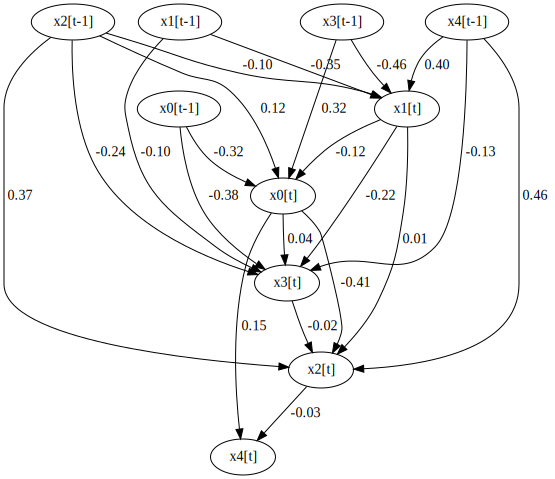

In [2]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/VARLiNGAM.ipynb
causal_graph_true = np.array([
    [
        [0,-0.12,0,0,0],
        [0,0,0,0,0],
        [-0.41,0.01,0,-0.02,0],
        [0.04,-0.22,0,0,0],
        [0.15,0,-0.03,0,0],
    ],
    [
        [-0.32,0,0.12,0.32,0],
        [0,-0.35,-0.1,-0.46,0.4],
        [0,0,0.37,0,0.46],
        [-0.38,-0.1,-0.24,0,-0.13],
        [0,0,0,0,0],
    ]
])
n_features = causal_graph_true.shape[1]
n_lags = len(causal_graph_true) - 1

concated = np.zeros((n_features * len(causal_graph_true), n_features * len(causal_graph_true)))
concated[:n_features, :] = np.concatenate(causal_graph_true, axis=1)
labels = [f"x{i}[t]" for i in range(n_features)] + [f"x{i}[t-1]" for i in range(n_features)]
display(make_dot(concated, labels=labels, lower_limit=0))

causal_order = [1, 0, 3, 2, 4]
# XXX: 誤差項の分散の占める割合を調整できないため、すべて1とする。
ratio_list = np.array([1, 1, 1, 1, 0.01])

sink_index = 4

def data_gen_time_series(causal_graph, errors, discrete_index=None):
    # VARについては倍の長さのerrorを与える。最初の方が不安定化もしれないため。出力はlen(errors)の半分になる。
    
    def _discretize(data, discrete_index):
        data[discrete_index] = (expit(data[discrete_index]) > np.random.uniform()).astype(int)
        return data
    
    def _x_t(X, e, B):
        _, n_features, _ = B.shape
        
        # (I - B_0)^-1
        term = np.linalg.pinv(np.eye(n_features) - B[0])

        # Sigma[B_tau @ x(t-tau)] + e(t)
        # Bは横につなげて、Xは縦につなげる
        # Bの2番目以降を横に連結、Xの最新からBの2番目以降との積をとる部分を縦に連結して、行列の積
        term2 = np.hstack(B[1:]) @ np.hstack(X[:, ::-1][:, :len(B) - 1]).reshape(n_features, 1) + e
        
        data = term @ term2
        
        if discrete_index is not None:
            data = _discretize(data, discrete_index)
        return data
    
    n_lags = len(causal_graph) - 1
    
    errors = errors.T
    
    X = errors[:, :n_lags]
    for t in range(n_lags, len(errors.T)):
        new_data = _x_t(X[:, :t], errors[:, [t]], causal_graph)
        X = np.append(X, new_data, axis=1)
    
    # エラーは元の長さのまま。Xは後ろ半分だけにする。
    return X[:, len(errors.T)//2:].T, errors.T

## 2. 実験

In [3]:
# 実験間で共通のデータ

# 誤差項: 誤差項は倍の長さが必要になるので注意。changing_exogでも。
sample_size = 1000
error = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    error.append(np.random.uniform(-a, a, size=sample_size*2))
error = np.array(error).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 離散変数
is_discrete = [False for _ in range(causal_graph_true.shape[1])]
is_discrete[sink_index] = True

# 評価関数
eval_funcs_c = {"mse": mean_squared_error}
eval_funcs_d = {"precision": precision_score, "recall": recall_score}

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x3->x4を削除)
causal_graph = causal_graph_true.copy()
causal_graph[0, 4, 3] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x0->x2を追加)
causal_graph = causal_graph_true.copy()
causal_graph[0, 2, 0] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x0->x3を10倍に設定)
causal_graph = causal_graph_true.copy()
causal_graph[0, 3, 0] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    cdt = CausalDigitalTwin(causal_graph_true, error, data_gen_time_series, sink_index, cd_algo_name="VARLiNGAM")
    result = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(continuous)", ml_models_c["rf"].best_params_)
    
    # sinkが連続&シャッフル
    result_shuffle = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    def data_gen_time_series_d(causal_graph, error):
        X_d, error = data_gen_time_series(causal_graph_true, error, discrete_index=sink_index)
        return X_d, error
    cdt = CausalDigitalTwin(causal_graph_true, error, data_gen_time_series_d, sink_index, is_discrete=is_discrete, cd_algo_name="VARLiNGAM")
    result_d = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"])
    
    print(info["name"], "cv_results_(discrete)", ml_models_d["rf"].best_params_)

    # sinkが離散&シャッフル
    result_d_shuffle = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)

    results[info["name"]] = {
        "continuous": result,
        "continuous_shuffle": result_shuffle,
        "discrete": result_d,
        "discrete_shuffle": result_d_shuffle,
    }

remove cv_results_(continuous) {'n_estimators': 200}
remove cv_results_(discrete) {'n_estimators': 200}
add cv_results_(continuous) {'n_estimators': 200}
add cv_results_(discrete) {'n_estimators': 200}
modify cv_results_(continuous) {'n_estimators': 200}
modify cv_results_(discrete) {'n_estimators': 50}


## 実験結果

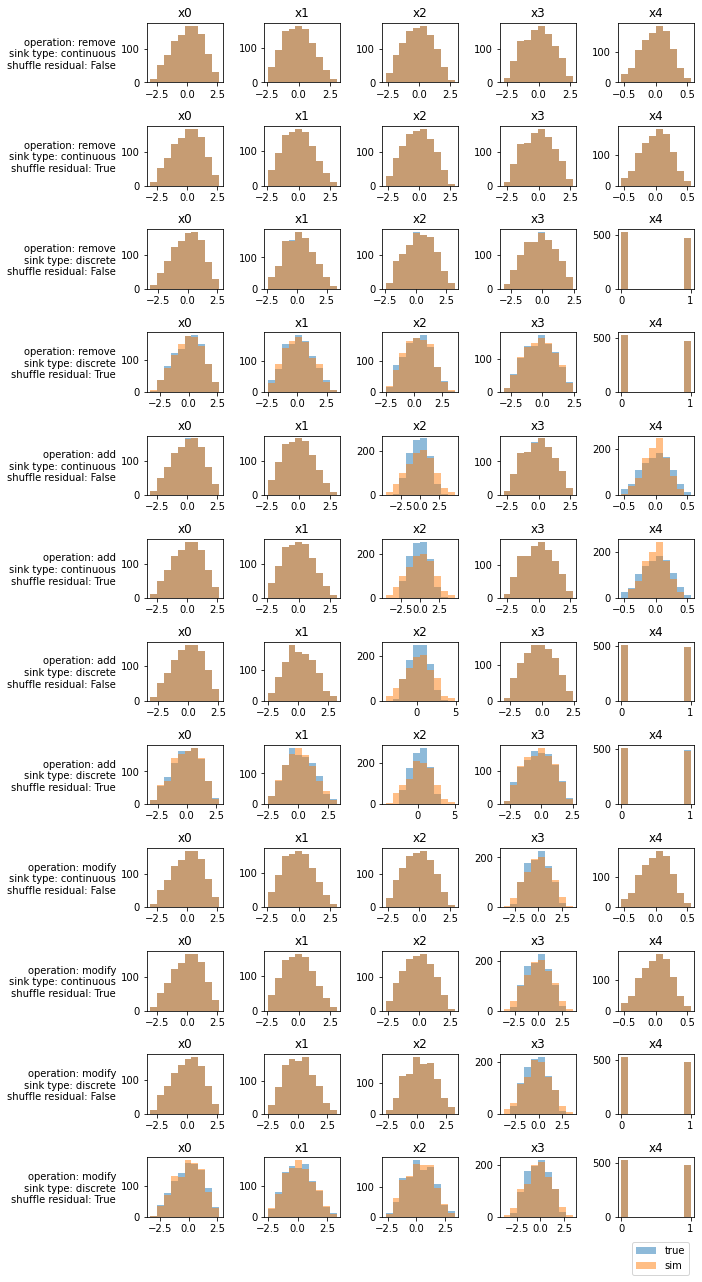

In [4]:
# 環境変化前の真のデータと環境変化後のシミュレーションデータ
n_features = len(causal_graph_true[0])
n_patterns = len(results) * len(results["add"])
draw_hist(n_features, n_patterns, results)

In [5]:
# シンク変数に対する機械学習モデルの精度
table_c, table_d = make_tables(results)
display(table_c.style.hide(axis="index"))
display(table_d.style.hide(axis="index"))

operation,model,shuffle error,MSE(true),MSE(sim),MSE(est)
remove,LinearRegression,False,0.010,0.111,0.010
remove,RandomForestRegressor,False,0.002,0.113,0.002
remove,LinearRegression,True,0.010,0.092,0.010
remove,RandomForestRegressor,True,0.002,0.097,0.002
add,LinearRegression,False,0.010,0.066,0.010
add,RandomForestRegressor,False,0.002,0.069,0.012
add,LinearRegression,True,0.010,0.052,0.010
add,RandomForestRegressor,True,0.002,0.058,0.013
modify,LinearRegression,False,0.010,0.109,0.010
modify,RandomForestRegressor,False,0.002,0.112,0.011


operation,model,shuffle error,Precision(true),Precision(sim),Precision(est),Recall(true),Recall(sim),Recall(est)
remove,LinearRegression,False,0.530,0.464,0.525,0.406,0.348,0.393
remove,RandomForestRegressor,False,1.000,0.485,0.505,1.000,0.476,0.464
remove,LinearRegression,True,0.530,0.492,0.592,0.406,0.372,0.447
remove,RandomForestRegressor,True,1.000,0.451,0.492,1.000,0.439,0.465
add,LinearRegression,False,0.554,0.414,0.515,0.494,0.388,0.496
add,RandomForestRegressor,False,1.000,0.435,0.480,0.998,0.465,0.491
add,LinearRegression,True,0.554,0.465,0.548,0.494,0.410,0.499
add,RandomForestRegressor,True,0.998,0.456,0.475,1.000,0.460,0.458
modify,LinearRegression,False,0.566,0.476,0.561,0.478,0.377,0.444
modify,RandomForestRegressor,False,1.000,0.514,0.529,1.000,0.481,0.468


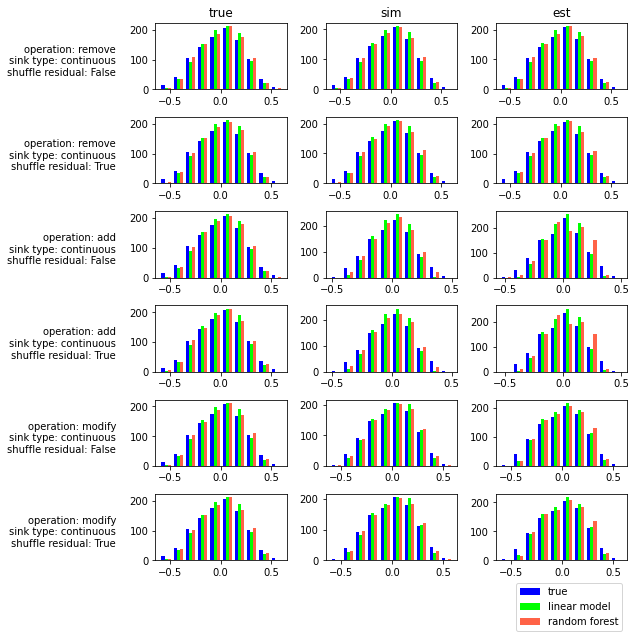

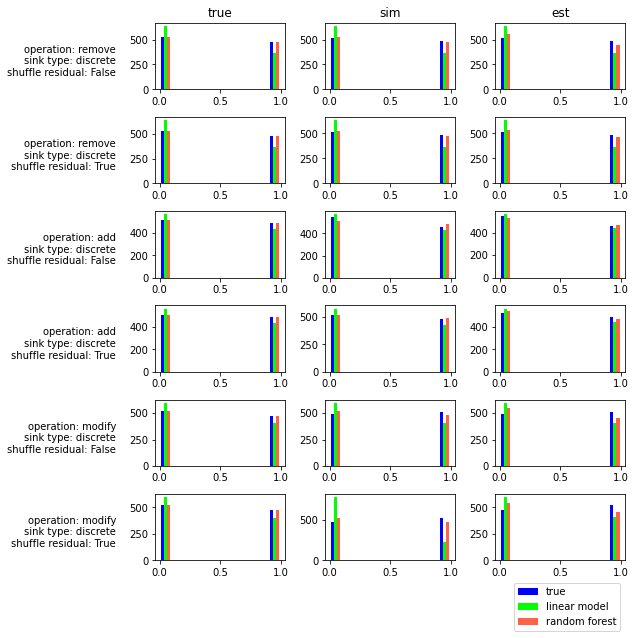

In [6]:
n_patterns = len(results) * len(results["add"])
draw_pred_hist(n_patterns, results, sink_index)